In [ ]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import requests #library to make http requests

#Enter where you want to store the training dataset (json file)
output_location = r'C:\Users\Keertan\OneDrive\Desktop\5sem\ML\inno\sarcasm.json'

url = 'https://storage.googleapis.com/learning-datasets/sarcasm.json' #downloading the dataset from google api
output_file = output_location

try:
    response = requests.get(url, stream=True) #Stream: receive data as chunks at a time
    response.raise_for_status() #Checks for error in http request response

    with open(output_file, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)

    print(f"File downloaded to {output_file}")
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")

File downloaded to C:\Users\Keertan\OneDrive\Desktop\5sem\ML\inno\sarcasm.json


In [ ]:
with open(output_location, 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
training_size = 20000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
max_length = 100
vocab_size = 20000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           320000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 320433 (1.22 MB)
Trainable params: 320433 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 5s - loss: 0.6618 - accuracy: 0.5871 - val_loss: 0.5622 - val_accuracy: 0.7700 - 5s/epoch - 8ms/step
Epoch 2/30
625/625 - 6s - loss: 0.4085 - accuracy: 0.8429 - val_loss: 0.3758 - val_accuracy: 0.8425 - 6s/epoch - 10ms/step
Epoch 3/30
625/625 - 6s - loss: 0.2852 - accuracy: 0.8898 - val_loss: 0.3446 - val_accuracy: 0.8572 - 6s/epoch - 10ms/step
Epoch 4/30
625/625 - 7s - loss: 0.2251 - accuracy: 0.9155 - val_loss: 0.3626 - val_accuracy: 0.8427 - 7s/epoch - 11ms/step
Epoch 5/30
625/625 - 4s - loss: 0.1839 - accuracy: 0.9316 - val_loss: 0.3422 - val_accuracy: 0.8581 - 4s/epoch - 7ms/step
Epoch 6/30
625/625 - 5s - loss: 0.1511 - accuracy: 0.9471 - val_loss: 0.3555 - val_accuracy: 0.8565 - 5s/epoch - 8ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1253 - accuracy: 0.9582 - val_loss: 0.3837 - val_accuracy: 0.8492 - 3s/epoch - 5ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1040 - accuracy: 0.9663 - val_loss: 0.3887 - val_accuracy: 0.8541 - 3s/epoch - 5ms/step
Epoch 9/30
625/625 - 

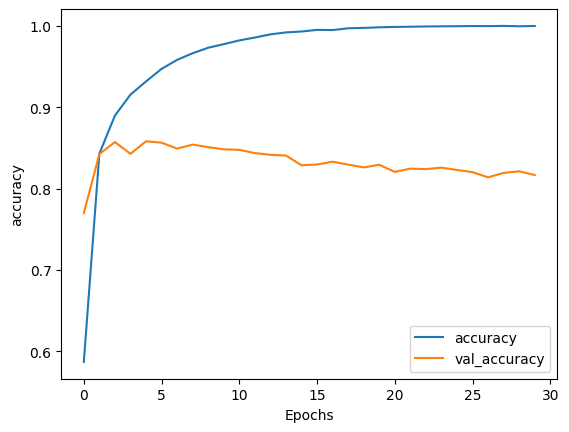

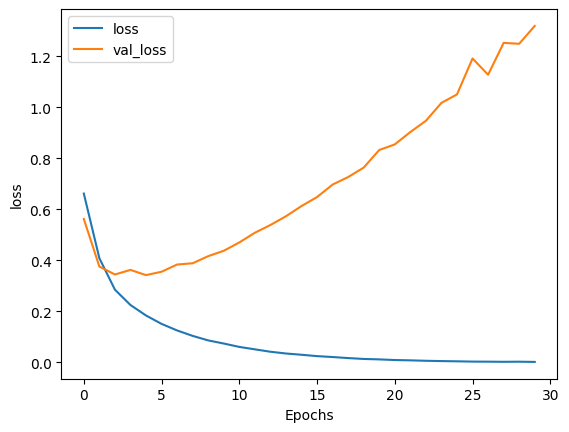

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former versace store clerk sues over secret 'black code' for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(20000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = ['you just broke my car window. Great job!',
           'you just saved my dog\'s life. Thanks a million!',
           'i just won a million dollars!']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
prediction = model.predict(padded)
print(prediction, sentence)

1/1 [==============================] - 0s 34ms/step
[[9.9995857e-01]
 [3.6344643e-09]
 [5.0735570e-12]] ['you just broke my car window. Great job!', "you just saved my dog's life. Thanks a million!", 'i just won a million dollars!']
